# Regresión Lineal

In [7]:
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [8]:
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [9]:
path = os.getcwd()
path = path.replace("\\", "\\\\")
path = path.replace("\\\\", "/")
path_data = "/".join(path.split("/")[:-1]) + "/Data/"
path_est = path_data + "Estandarizada/"

In [10]:
df = pd.read_csv(path_est + "data_refined.csv", keep_default_na=False, na_values="", sep=',')
df['FECHA'] = pd.to_datetime(df.FECHA).dt.to_period('m')

In [6]:
#Crear un objeto FeatureHasher
fh = FeatureHasher(n_features=6, input_type='string')
#Transformar la variable categórica utilizando la codificación Hashing
hashed = fh.transform(df['PROVINCIA'])
#Convertir el resultado en un dataframe
hashed_df = pd.DataFrame(hashed.toarray())
#Unir el dataframe original con el dataframe de características codificadas
df = pd.concat([df, hashed_df], axis=1)
df = df.drop(columns=['PROVINCIA'])
df.rename(columns = {0:'HASH_0'}, inplace = True)
df.rename(columns = {1:'HASH_1'}, inplace = True)
df.rename(columns = {2:'HASH_2'}, inplace = True)
df.rename(columns = {3:'HASH_3'}, inplace = True)
df.rename(columns = {4:'HASH_4'}, inplace = True)
df.rename(columns = {5:'HASH_5'}, inplace = True)

In [6]:
df

,FECHA,ALTITUD,TEMP_MED,PREC,DIR,VEL_MEDIA,RACHA,PRES_MIN,SOL,TASA_INCIDENCIA,HASH_0,HASH_1,HASH_2,HASH_3,HASH_4,HASH_5
0,2020-01,58.0,11.519355,3.848387,23.580645,3.706452,12.183871,1013.903226,3.838710,0.09,0.0,0.0,1.0,-1.0,2.0,0.0
1,2020-01,674.0,6.996774,1.354839,32.483871,0.916129,6.451613,945.961290,5.474194,0.00,0.0,-1.0,-1.0,0.0,2.0,0.0
2,2020-01,81.0,11.664516,1.193548,22.000000,1.767742,7.741935,1013.180645,6.896774,0.00,1.0,-1.0,0.0,-1.0,2.0,-1.0
3,2020-01,21.0,12.487097,0.690323,53.967742,3.425806,9.629032,1020.690323,6.409677,0.00,1.0,0.0,0.0,1.0,3.0,0.0
4,2020-01,513.0,5.445161,0.948387,54.516129,3.229032,10.045161,963.483871,3.254839,0.00,0.0,0.0,-1.0,2.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,2023-02,690.0,5.757143,0.028571,19.892857,3.935714,11.978571,940.478571,7.700000,40.03,0.0,-1.0,1.0,0.0,2.0,0.0
1972,2023-02,56.0,9.582143,1.014286,59.678571,2.817857,8.164286,1015.625000,6.250000,24.16,1.0,0.0,0.0,0.0,2.0,-1.0
1973,2023-02,846.0,4.242857,0.267857,13.107143,3.760714,9.750000,924.460714,7.260714,78.59,1.0,0.0,2.0,-2.0,3.0,0.0
1974,2023-02,715.0,5.128571,0.335714,20.071429,1.757143,8.932143,939.407143,6.792857,183.92,0.0,0.0,0.0,1.0,4.0,1.0


In [7]:
df = df.assign(MONTH = lambda x: (x['FECHA'].astype(str).str.slice(start=5).astype(int)))

In [8]:
df.dtypes

FECHA              period[M]
ALTITUD              float64
TEMP_MED             float64
PREC                 float64
DIR                  float64
VEL_MEDIA            float64
RACHA                float64
PRES_MIN             float64
SOL                  float64
TASA_INCIDENCIA      float64
HASH_0               float64
HASH_1               float64
HASH_2               float64
HASH_3               float64
HASH_4               float64
HASH_5               float64
MONTH                  int32
dtype: object

In [9]:
selected_features = ['MONTH', 'ALTITUD', 'TEMP_MED', 'PREC', 'DIR', 'VEL_MEDIA', 'RACHA', 'PRES_MIN', 'SOL'
                     ,'HASH_0', 'HASH_1', 'HASH_2', 'HASH_3', 'HASH_4', 'HASH_5']

In [10]:
train = df[(df['FECHA'] >= '2020-01-01 00:00:00') & (df['FECHA'] <= '2022-02-28 23:59:59')]
test  = df[(df['FECHA'] >= '2022-03-01 00:00:00')]
print(round(test.shape[0]/df.shape[0], 2))

0.32


In [11]:
# División de los datos en train y test
# ==============================================================================
# X = train[selected_features]
# y = train['TASA_INCIDENCIA']


X_train = train[selected_features]
X_test  = test[selected_features]
y_train = train['TASA_INCIDENCIA'].values.reshape(-1,1)
y_test  = test['TASA_INCIDENCIA'].values.reshape(-1,1)

## División de los datos en train y test

X = df[selected_features]
y = df['TASA_INCIDENCIA']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [12]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     24.18
Date:                Thu, 11 May 2023   Prob (F-statistic):           1.21e-59
Time:                        15:55:31   Log-Likelihood:                -11794.
No. Observations:                1352   AIC:                         2.362e+04
Df Residuals:                    1336   BIC:                         2.370e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.352e+05   1.46e+04     -9.287      0.0

In [13]:
intervalos_ci = modelo.conf_int(alpha=0.05)
intervalos_ci.columns = ['2.5%', '97.5%']
intervalos_ci

,2.5%,97.5%
const,-163735.936972,-106623.868384
MONTH,10.332870,62.090527
ALTITUD,11.521664,17.837460
TEMP_MED,-153.212835,-103.245644
PREC,-61.298768,50.192168
DIR,-6.261303,8.501253
VEL_MEDIA,-195.636428,121.972708
RACHA,-86.059116,114.958034
PRES_MIN,106.966768,162.481804
SOL,97.990305,213.704901


In [14]:
y_train = y_train.flatten()
prediccion_train = modelo.predict(exog = X_train)
residuos_train   = prediccion_train - y_train

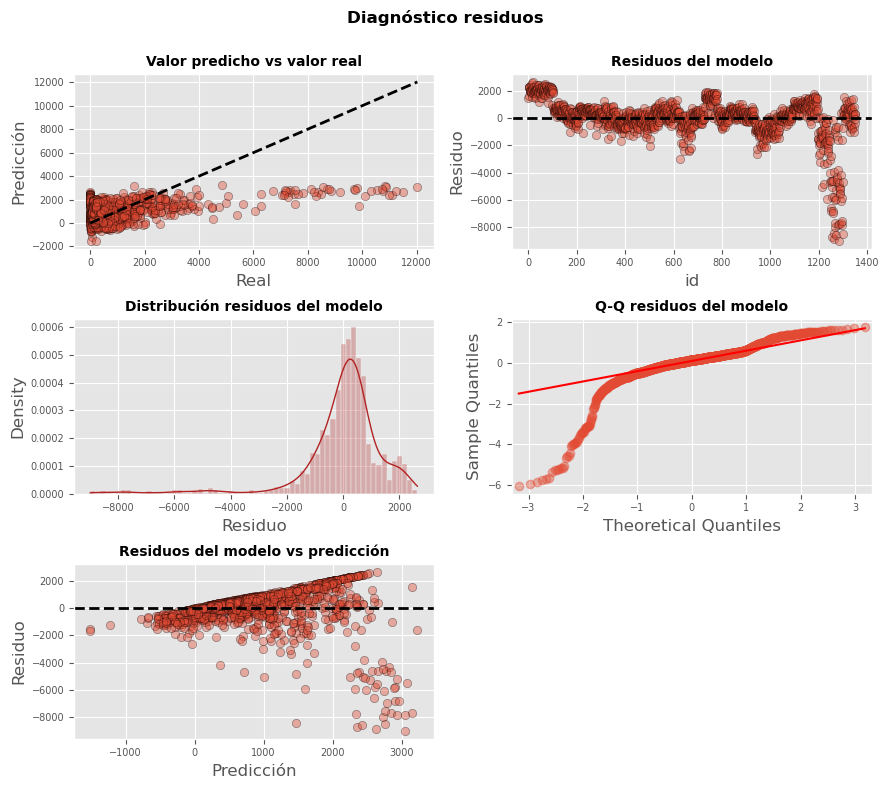

In [15]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [16]:
# Normalidad de los residuos Shapiro-Wilk test
shapiro_test = stats.shapiro(residuos_train)
shapiro_test

ShapiroResult(statistic=0.7664477825164795, pvalue=4.271283836123832e-40)

In [17]:
# Normalidad de los residuos D'Agostino's K-squared test
k2, p_value = stats.normaltest(residuos_train)
print(f"Estadítico= {k2}, p-value = {p_value}")

Estadítico= 807.9703187003076, p-value = 3.560201045762642e-176


In [18]:
predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predicciones.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1479.810685,183.082870,1120.649473,1838.971897,-1475.429383,4435.050753
1,2252.292457,163.527032,1931.494737,2573.090177,-698.530862,5203.115776
2,2256.356184,147.551144,1966.899022,2545.813345,-691.224609,5203.936977
3,2241.605025,133.790151,1979.143372,2504.066678,-703.447301,5186.657351


In [19]:
# Error de test del modelo 
X_test = sm.add_constant(X_test, prepend=True)
predicciones = modelo.predict(exog = X_test)
mse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = True
       )
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
mae =  mean_absolute_error( y_true  = y_test, y_pred  = predicciones)
print("")
print(f"El error (mse) de test es: {mse}")
print("")
print(f"El error (rmse) de test es: {rmse}")
print("")
print(f"El error (mae) de test es: {mae}")


El error (mse) de test es: 918447.5214419919

El error (rmse) de test es: 958.3566775694694

El error (mae) de test es: 678.1046249156058
